# Deep Learning groep 3

Team Diep Leren en Opereren
Groepsleden:
- Casper Priem - casperpriem
- Lars Timmer - laltir
- Matthias de Vreede - matthiasdevreede
- Willem van Dijk - willemvandijk

## Pre-requisites

In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.image as mpimg
import geopandas as gpd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, LeakyReLU, ELU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from tensorflow.keras.utils import plot_model


## Exploratory Data Analysis 

### First Look

In [2]:
df = pd.read_csv('train.csv')

In [9]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   House ID   500 non-null    int64  
 1   Bedrooms   500 non-null    int64  
 2   Bathrooms  500 non-null    float64
 3   Area       500 non-null    int64  
 4   Latitude   500 non-null    float64
 5   Longitude  500 non-null    float64
 6   Price      500 non-null    int64  
dtypes: float64(3), int64(4)
memory usage: 27.5 KB


,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude,Price
count,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,5.000000e+02
mean,250.500000,3.350000,2.669500,2369.64600,35.128844,-116.469049,5.980218e+05
std,144.481833,1.172283,1.017578,1208.18261,2.386173,6.554434,5.240649e+05
min,1.000000,1.000000,1.000000,701.00000,32.631500,-122.368300,2.200000e+04
25%,125.750000,2.000000,2.000000,1440.00000,33.808200,-119.802500,2.350000e+05
50%,250.500000,3.000000,2.500000,2097.50000,33.920800,-117.609600,5.300000e+05
75%,375.250000,4.000000,3.000000,3104.50000,35.640600,-116.371300,7.490000e+05
max,500.000000,10.000000,7.000000,9583.00000,47.791800,-87.885900,5.858000e+06


### Plot graphs

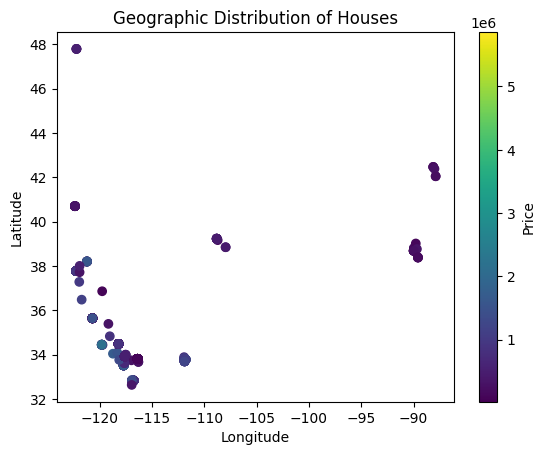

In [10]:
plt.scatter(df['Longitude'], df['Latitude'], 
            c=df['Price'], cmap='viridis')
plt.colorbar(label='Price')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title("Geographic Distribution of Houses")
plt.show()

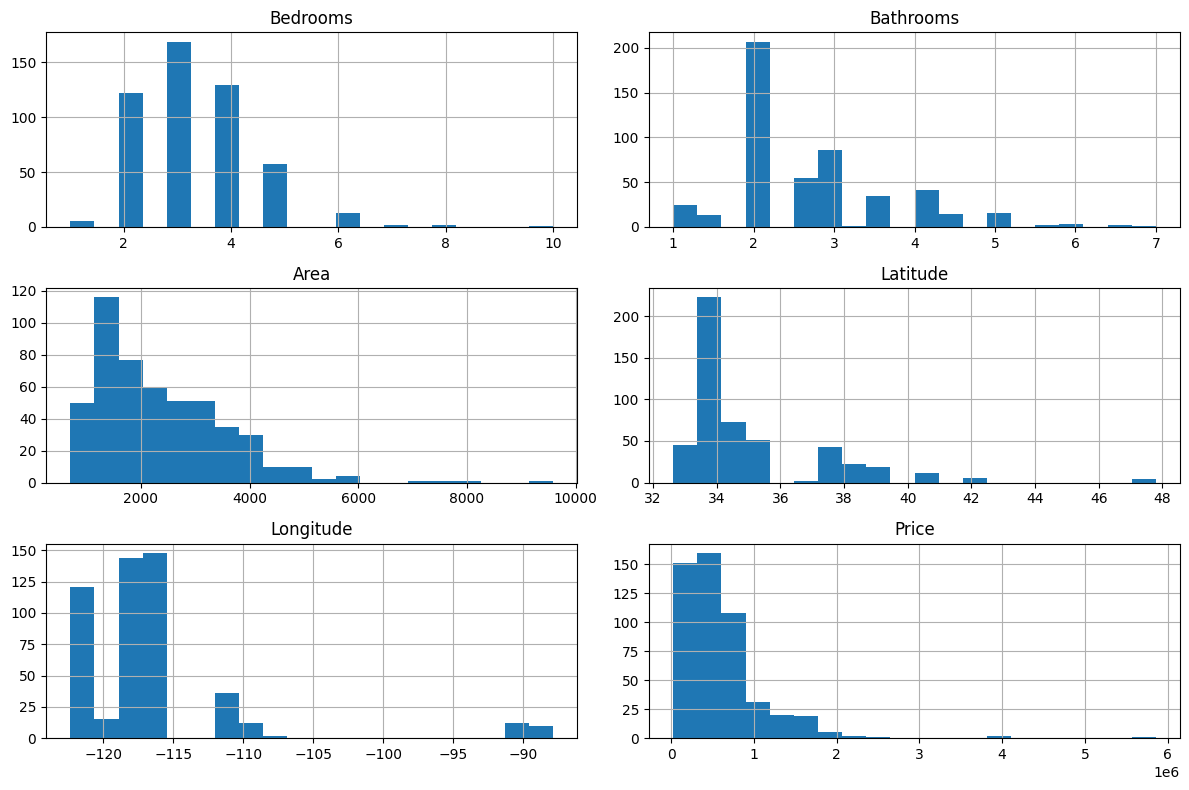

In [11]:
numeric_cols = ["Bedrooms", "Bathrooms", "Area", "Latitude", "Longitude", "Price"]
df[numeric_cols].hist(figsize=(12, 8), bins=20)
plt.tight_layout()
plt.show()


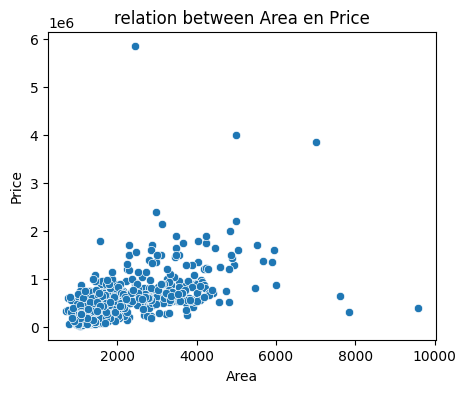

In [12]:
plt.figure(figsize=(5, 4))
sns.scatterplot(x="Area", y="Price", data=df)
plt.title("relation between Area en Price")
plt.show()


### Correlations

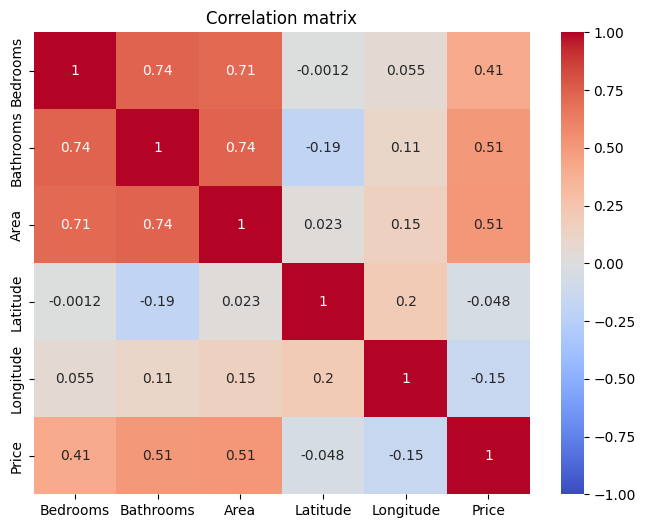

In [13]:
corr = df[numeric_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation matrix")
plt.show()


### Outliers


In [3]:
Q1 = df["Price"].quantile(0.25)
Q3 = df["Price"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

outliers = df[(df["Price"] < lower_bound) | (df["Price"] > upper_bound)]
print("Amount of outliers :", outliers.shape[0])


Amount of outliers : 23


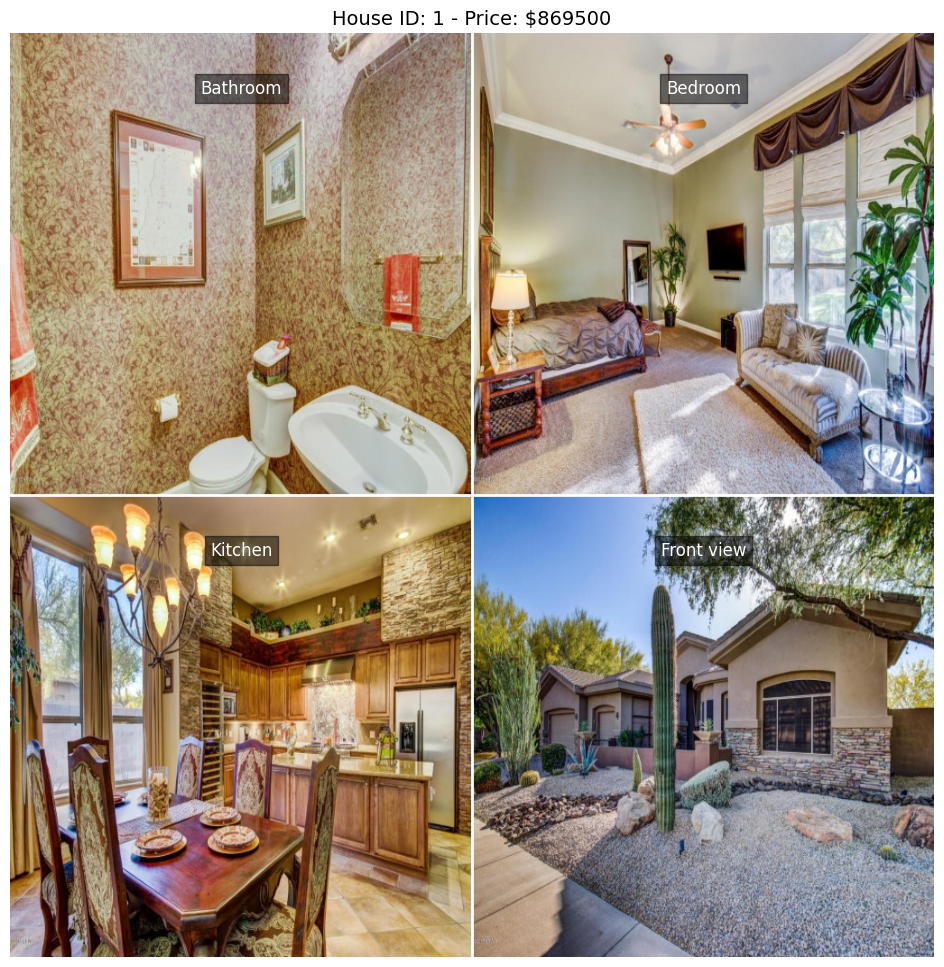

In [15]:
def display_house(house_id, df, folder='Train'):

    house_data = df.loc[df["House ID"] == house_id]
    if house_data.empty:
        print(f"House ID {house_id} Not Found")
        return
    
    num_bathrooms = house_data["Price"].values[0]
    filename = f"{house_id}.jpg"
    img_path = os.path.join(folder, filename)
    
    if not os.path.exists(img_path):
        print(f"File not found: {img_path}")
        return
    
    img = mpimg.imread(img_path)
    height, width, _ = img.shape
    

    plt.figure(figsize=(12,12))
    plt.imshow(img)
    plt.title(f"House ID: {house_id} - Price: ${num_bathrooms}", fontsize=14)
    plt.axis('off')
    
    plt.axvline(x=width/2, color='white', linewidth=2)
    plt.axhline(y=height/2, color='white', linewidth=2)

    plt.text(width*0.25, height*0.05, "Bathroom",
             color='white', fontsize=12, ha='center', va='top',
             bbox=dict(facecolor='black', alpha=0.5))
    plt.text(width*0.75, height*0.05, "Bedroom",
             color='white', fontsize=12, ha='center', va='top',
             bbox=dict(facecolor='black', alpha=0.5))
    plt.text(width*0.25, height*0.55, "Kitchen",
             color='white', fontsize=12, ha='center', va='top',
             bbox=dict(facecolor='black', alpha=0.5))
    plt.text(width*0.75, height*0.55, "Front view",
             color='white', fontsize=12, ha='center', va='top',
             bbox=dict(facecolor='black', alpha=0.5))

    plt.show()


display_house(1, df, folder='Train') # Display the house with ID 1, ID can be changed to any other ID


In [16]:
house_ids = df["House ID"].values

### Data Preparation

In [18]:
import cv2
def load_and_preprocess_image(house_id, folder='Train', img_size=(224, 224)):

    filename = f"{house_id}.jpg"
    path = os.path.join(folder, filename)
    
    img = cv2.imread(path)               
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size)
    img = img / 255.0
    return img


images = []
for hid in house_ids:
    img_array = load_and_preprocess_image(hid, folder='Train')
    images.append(img_array)

images = np.array(images)


Features for csv data

In [8]:
train = pd.read_csv('train.csv')

source  https://www.naturalearthdata.com/downloads/10m-physical-vectors/10m-coastline/

https://chatgpt.com/share/67dfde94-77f8-800b-93cc-ffa3c0778312


In [10]:
coastline = gpd.read_file("ne_10m_coastline.shp")
gdf_properties = gpd.GeoDataFrame(
    train,
    geometry=gpd.points_from_xy(train.Longitude, train.Latitude),
    crs="EPSG:4326"  # WGS84 Latitude/Longitude
)
gdf_properties = gdf_properties.to_crs(epsg=3857)
coastline = coastline.to_crs(epsg=3857)
train['distance_to_coast_m'] = gdf_properties.geometry.apply(
    lambda point: coastline.distance(point).min()
)

print(train.head())



c:\Users\caspe\OneDrive\Documents\GitHub\DeepLearning\.venv\Lib\site-packages\shapely\measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


   House ID  Bedrooms  Bathrooms  Area  Latitude  Longitude   Price  \
0         1         4        4.0  4053   33.6968  -111.8892  869500   
1         2         4        3.0  3343   34.8280  -119.0349  865200   
2         3         3        4.0  3923   33.7669  -111.9182  889000   
3         4         5        5.0  4022   33.7752  -111.7791  910000   
4         5         3        4.0  4116   33.7669  -111.9182  971226   

   distance_to_coast_m  
0        350887.562039  
1         77530.449791  
2        356761.999625  
3        366151.192977  
4        356761.999625  


In [11]:
#apply the same on test.csv
test = pd.read_csv('test.csv')
gdf_properties = gpd.GeoDataFrame(
    test,
    geometry=gpd.points_from_xy(test.Longitude, test.Latitude),
    crs="EPSG:4326"
)
gdf_properties = gdf_properties.to_crs(epsg=3857)
test['distance_to_coast_m'] = gdf_properties.geometry.apply(
    lambda point: coastline.distance(point).min()
)


c:\Users\caspe\OneDrive\Documents\GitHub\DeepLearning\.venv\Lib\site-packages\shapely\measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


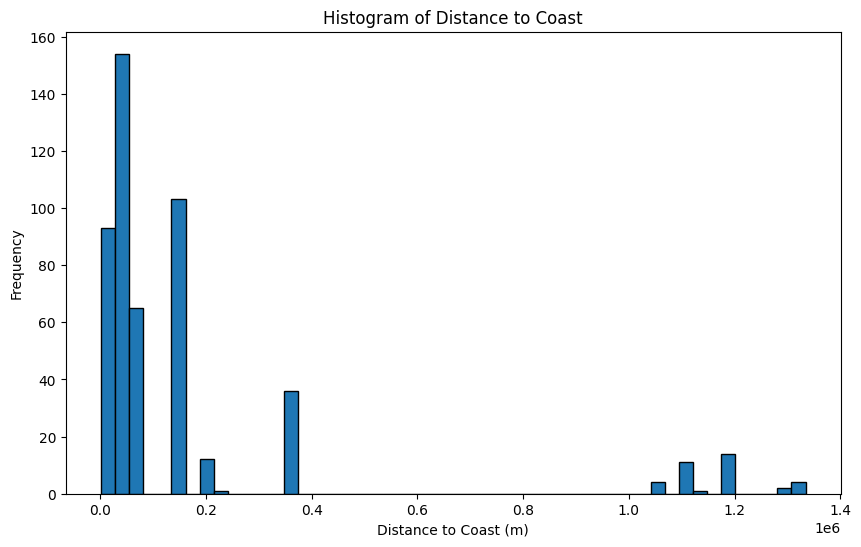

In [7]:
plt.figure(figsize=(10, 6))
plt.hist(train['distance_to_coast_m'], bins=50, edgecolor='black')
plt.title('Histogram of Distance to Coast')
plt.xlabel('Distance to Coast (m)')
plt.ylabel('Frequency')
plt.show()

In [24]:
from sklearn.cluster import KMeans
distances = np.array(train['distance_to_coast_m'])
distances_reshaped = distances.reshape(-1, 1)

# fit KMeans with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=0).fit(distances_reshaped)
labels = kmeans.labels_

# Create a new column in 'train' to store cluster labels
train['cluster'] = labels

# Compute mean distance for each cluster
cluster_0 = train[train['cluster'] == 0]['distance_to_coast_m']
cluster_1 = train[train['cluster'] == 1]['distance_to_coast_m']

mean_0 = cluster_0.mean()
mean_1 = cluster_1.mean()

print("Mean distance of cluster 0:", mean_0)
print("Mean distance of cluster 1:", mean_1)

mean_prices = train.groupby('cluster')['Price'].mean()
print(mean_prices)


Mean distance of cluster 0: 89295.972066417
Mean distance of cluster 1: 1165174.2876889803
cluster
0    619745.497845
1    318027.750000
Name: Price, dtype: float64


In [25]:
train.drop('cluster', axis=1, inplace=True)

In [ ]:

lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR
train = train[(train["Price"] >= lower_bound) & (train["Price"] <= upper_bound)]
train.reset_index(drop=True, inplace=True)

print(f"Shape after removing outliers: {train.shape}")

Shape after removing outliers: (477, 8)


## Modelling

### Fully-connected Neural Network

#### Model building

In [27]:
# 1. Data inladen
df = train

# Definieer features en target
feature_cols = ["Bedrooms", "Bathrooms", "Area", "Latitude", "Longitude", "distance_to_coast_m"]
target_col = "Price"

X = df[feature_cols].values
y = np.log1p(df[target_col].values)



# 2. Splits de data in training en test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Bepaal de initiële bias op basis van het gemiddelde van de log-getransformeerde target
initial_bias = np.log1p(df[target_col].mean())

# 4. Model bouwen met Keras Tuner
def build_model(hp):
    # Kies tussen 'leaky' of 'elu' activation
    activation_choice = hp.Choice('activation', values=['leaky', 'elu'])
    if activation_choice == 'leaky':
        def activation_layer():
            return LeakyReLU(negative_slope=hp.Float('leaky_slope', 0.05, 0.2, step=0.05))
    else:
        def activation_layer():
            return ELU(alpha=hp.Float('elu_alpha', 0.8, 1.2, step=0.1))
    
    # Tune L2
    reg = l2(hp.Float('l2_reg', 1e-5, 1e-3, sampling='LOG'))
    
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(units=hp.Int('units1', min_value=64, max_value=256, step=32), kernel_regularizer=reg),
        BatchNormalization(),
        activation_layer(),
        Dropout(rate=hp.Float('dropout1', 0.0, 0.5, step=0.05)),
        
        Dense(units=hp.Int('units2', min_value=32, max_value=128, step=16), kernel_regularizer=reg),
        BatchNormalization(),
        activation_layer(),
        Dropout(rate=hp.Float('dropout2', 0.0, 0.5, step=0.05)),
        
        Dense(units=hp.Int('units3', min_value=16, max_value=64, step=16), kernel_regularizer=reg),
        BatchNormalization(),
        activation_layer(),
        Dropout(rate=hp.Float('dropout3', 0.0, 0.5, step=0.05)),
        
        # Outputlaag met een bias zodat de output begint dicht bij het gemiddelde van de log-transformatie
        Dense(1, activation='linear', bias_initializer=tf.keras.initializers.Constant(initial_bias))
    ])
    
    # Tune de learning rate
    lr = hp.Float('lr', 1e-4, 1e-2, sampling='LOG')
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(
        optimizer=optimizer,
        loss='mean_squared_error',
        metrics=['mae', 'mean_absolute_percentage_error']
    )
    return model

# 5. Zet de tuner op
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=30,
    executions_per_trial=1,
    directory='my_tuner_dir',
    project_name='house_price_tuning_extended_outliers_removed'
)

# 6. Start de hyperparameter tuning
tuner.search(X_train, y_train, epochs=100, validation_split=0.2,
             callbacks=[EarlyStopping(patience=20, restore_best_weights=True)],
             verbose=1)

# Haal het beste model op
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

# 7. Evalueer het model op de testset (op de getransformeerde schaal)
test_loss, test_mae, test_mape = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Test MAPE (log-scale): {test_mape:.4f}")


y_pred_log = best_model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

mape_original = mean_absolute_percentage_error(y_true, y_pred)
print(f"Test MAPE (original scale): {mape_original*100:.2f}%")



Reloading Tuner from my_tuner_dir\house_price_tuning_extended_outliers_removed\tuner0.json



c:\Users\caspe\OneDrive\Documents\GitHub\DeepLearning\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elu (ELU)                       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 112)            │        28,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112)            │           448 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elu_1 (ELU)                     │ (None, 112)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 112)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 48)             │         5,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 48)             │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elu_2 (ELU)                     │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,713 (147.32 KB)

 Trainable params: 36,881 (144.07 KB)

 Non-trainable params: 832 (3.25 KB)

Test MAPE (log-scale): 2.2168
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Test MAPE (original scale): 28.74%


with outliers

Test MAPE (original scale): 37.64%

Kaggle score : Score: 0.59631

without outliers

Test MAPE (original scale): 28.74%

Kaggle score : Score:  0.64871


In [28]:
feature_cols = ["Bedrooms", "Bathrooms", "Area", "Latitude", "Longitude", "distance_to_coast_m"]
X_test_new = test[feature_cols].values

# Predict using the best model (trained on log-transformed target values)
y_pred_log = best_model.predict(X_test_new)

# Invert the log transformation (np.expm1 is the inverse of np.log1p)
y_pred = np.expm1(y_pred_log)


submission = pd.DataFrame({
    'House ID': test['House ID'],
    'PredictedPrice': y_pred.flatten()
})

submission.to_csv('submission_with_dropout_L2.csv', index=False)
submission.head()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


,House ID,PredictedPrice
0,501,605600.37500
1,502,426474.53125
2,503,448319.93750
3,504,658434.06250
4,505,614218.06250


#### Model Visualisation

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8415 - mae: 0.6052 - mean_absolute_percentage_error: 4.7742 - val_loss: 0.2516 - val_mae: 0.3701 - val_mean_absolute_percentage_error: 2.9844
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7194 - mae: 0.6380 - mean_absolute_percentage_error: 4.9904 - val_loss: 0.2468 - val_mae: 0.3613 - val_mean_absolute_percentage_error: 2.9169
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6097 - mae: 0.5833 - mean_absolute_percentage_error: 4.5738 - val_loss: 0.2375 - val_mae: 0.3638 - val_mean_absolute_percentage_error: 2.9202
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5917 - mae: 0.5798 - mean_absolute_percentage_error: 4.5501 - val_loss: 0.2372 - val_mae: 0.3713 - val_mean_absolute_percentage_error: 2.9628
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5596 - mae: 0.5771 - mean_absolute_percentage_error: 4.5569 - val_loss: 0.2343 - val_mae: 0.3688 - val_mean_absolute_percentag

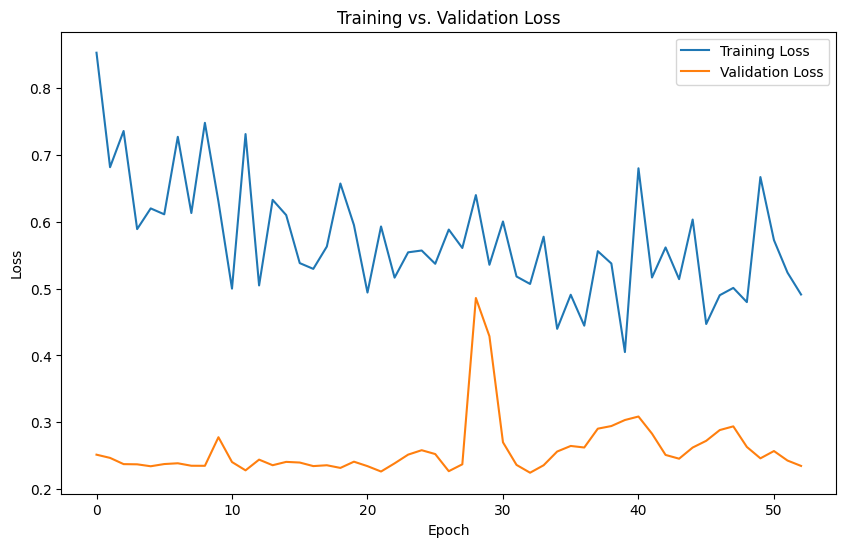

In [33]:
history = best_model.fit(X_train, y_train, epochs=100, validation_split=0.2,
                         callbacks=[EarlyStopping(patience=20, restore_best_weights=True)],
                         verbose=1)

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.show()


#### Model Explanation


##### Data Preparation 
- Features & Target:
The input features are numerical columns such as Bedrooms, Bathrooms, Area, Latitude, Longitude, and distance to coast. The target variable is the house price, but it’s transformed using a np.log1p to stabilize variance and help the model learn better.

- Initial Bias:
The model’s final layer is initialized with a bias equal to the average log-transformed price. This gives the network a good starting point so that its initial predictions are near the mean value. (also the reason I removed outliers so that the mean is more MEANingfull)

- Additional feature:
We have added distance_to_coast_m it spans from ~1.3 km to 1,334 km – a highly skewed distribution (most houses are tens of km from the coast, with a few extremely far inland). The data of the coastline is in the github as ne_10m_coastline.shp


##### Model 
- Dense Layers:
There are three fully-connected (Dense) hidden layers. The number of units in each Dense layer is tuned (for the first layer between 64 and 256 units, for the second between 32 and 128, and for the third between 16 and 64). Each Dense layer uses L2 regularization (with its strength also tuned), which helps prevent overfitting by penalizing large weight values.

- Batch Normalization:
After each Dense layer BatchNormalization is applied. This normalizes the output of the layer.

- Activation Layers:
The activation is chosen via hyperparameter tuning:
If ‘leaky’ is chosen, a LeakyReLU is used (with its negative slope tuned between 0.05 and 0.2).
Otherwise, an ELU is applied (with its alpha tuned between 0.8 and 1.2).
These activations add non-linearity to the model, allowing it to learn complex relationships.

- Dropout Layers:
After each activation, a Dropout layer is included. Dropout randomly “turns off” a fraction of neurons during training (with the dropout rate tuned between 0 and 0.5) to help prevent overfitting.

- Output Layer:
The final Dense layer has 1 neuron with a linear activation. The bias for this layer is set to the initial bias (average of the log target) so that it starts off with predictions near the mean value.


##### Training

- Optimizer & Learning Rate:
The model uses the Adam optimizer, which adapts the learning rate for each parameter. The learning rate itself is tuned (between 1e-4 and 1e-2).

- Loss Function & Metrics:
The loss function is Mean Squared Error (MSE), which is common for regression tasks and punishes big differences to reduce MAPE.

- Early Stopping:
The training uses an EarlyStopping callback with a patience of 20 epochs. This means if the validation loss doesn’t improve for 20 epochs, training stops and the best weights are restored.


- Hyperparameter Tuning:
The model is wrapped in a Keras Tuner RandomSearch, which explores different hyperparameter combinations (like the number of units, dropout rates, learning rate, activation type, etc.) to find the best settings based on validation loss.


##### Conclusion

Based on the training vs val loss graph you can see the loss fluctuating, this could be due to not enough data or noise. You can also tell that there is likely no overfitting since the VAL loss is lower or comparable to training loss most of the time.
After submitting the score on Kaggle you can see that the model is bad.

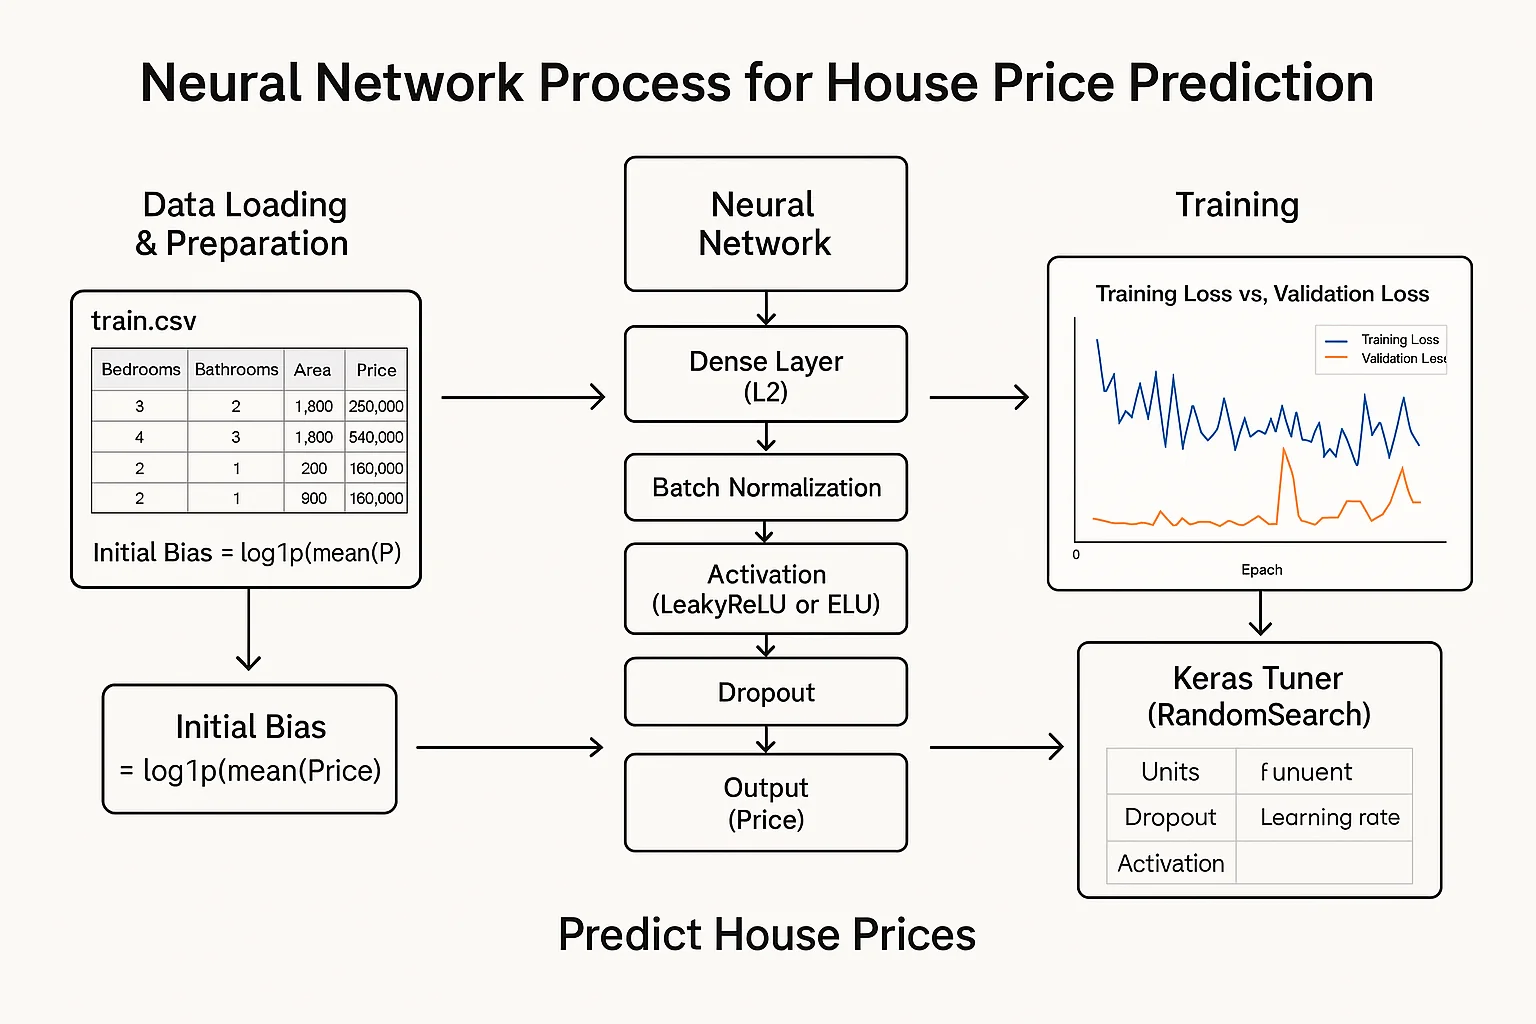

Generated with Sora AI from ChatGPT

Sources:

https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanSquaredError

https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/l2

https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization

https://www.tensorflow.org/api_docs/python/tf/keras/layers/LeakyReLU

https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout

https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam

https://keras.io/keras_tuner/


#### Model compilation

### Convolutional Neural Network

#### Model building

In [93]:
import pathlib
import tensorflow as tf

# Define paths using pathlib
cnn__train_df = pathlib.Path("Train/")  # Fix the empty string to "Train/"
cnn_test_df = pathlib.Path("Test/")

# Hyperparameters
batch_size = 32
img_height = 180
img_width = 180

# Load Train dataset (split into training and validation)
train_ds = tf.keras.utils.image_dataset_from_directory(
    cnn__train_df,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    cnn__train_df,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Load Test dataset (no validation split)
test_ds = tf.keras.utils.image_dataset_from_directory(
    cnn_test_df,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Print dataset details
print(f"Train batches: {len(train_ds)}, Validation batches: {len(val_ds)}, Test batches: {len(test_ds)}")


Found 500 files belonging to 1 classes.
Using 400 files for training.
Found 500 files belonging to 1 classes.
Using 100 files for validation.
Found 35 files belonging to 1 classes.
Train batches: 13, Validation batches: 4, Test batches: 2


In [169]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

# Load CSV
df = pd.read_csv("train.csv")

# Define image size (e.g., 224x224 for ResNet or MobileNet)
IMG_SIZE = (224, 224)
IMG_DIR = "train/house"

# Load images and labels
def load_image(filename):
    path = os.path.join(IMG_DIR, f"{str(filename)}.jpg")  # Ensure filename is a string
    img = load_img(path, target_size=IMG_SIZE)  # Resize image
    img = img_to_array(img) / 255.0  # Normalize
    return img

# Apply the function
X = np.array([load_image(f) for f in df["House ID"]])
y = np.array(df["Price"])  # Regression target

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

 

In [173]:
from sklearn.preprocessing import MinMaxScaler

# Reshape your target labels to 2D for scaling
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.reshape(-1, 1))
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)

y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001EC19AED9E0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step 


Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 486ms/step - loss: 1.4870 - mean_absolute_error: 0.0901 - val_loss: 0.5238 - val_mean_absolute_error: 0.0539
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 467ms/step - loss: 0.4013 - mean_absolute_error: 0.0570 - val_loss: 0.2416 - val_mean_absolute_error: 0.0546
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 455ms/step - loss: 0.2061 - mean_absolute_error: 0.0616 - val_loss: 0.1233 - val_mean_absolute_error: 0.0547
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 472ms/step - loss: 0.1090 - mean_absolute_error: 0.0590 - val_loss: 0.0671 - val_mean_absolute_error: 0.0538
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 448ms/step - loss: 0.0601 - mean_absolute_error: 0.0535 - val_loss: 0.0394 - val_mean_absolute_error: 0.0663
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 453ms/step - loss: 0.0373 - mean_absolute_error: 0.0605 - val_loss: 0.0235 - val_mean_absolute_error: 0.0535
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 452ms/step - loss: 0.0265 - mean_absolute_error: 0.0

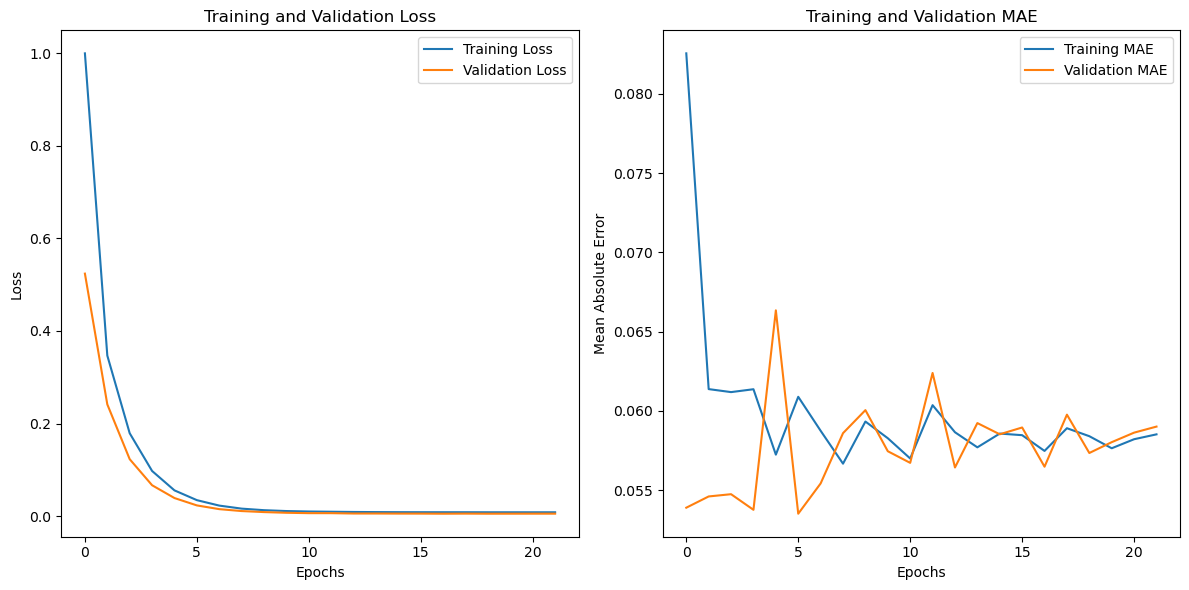

In [178]:
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
# Define Model

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),

    layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(1)
])
# Compile Model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="mse", metrics=["mean_absolute_error"])

# Define EarlyStopping Callback
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Fit the model and store the training history
history = model.fit(X_train, y_train_scaled, epochs=100, batch_size=32, validation_data=(X_test, y_test_scaled), callbacks=[stop_early])

# Plotting training and validation loss and MAE
plt.figure(figsize=(12, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot training and validation mean absolute error
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('Training and Validation MAE')

plt.tight_layout()
plt.show()


In [141]:
# Evaluate model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {mae}")

# Predict
predictions = model.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 174515519488.0000 - mae: 319344.3125
Test MAE: 331068.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


In [ ]:
# Get image ids from test set and convert to unicode
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')

# Write the submission file
np.savetxt(
    'submission.csv',
    np.rec.fromarrays([test_ids, predictions]),
    fmt=['%s', '%d'],
    delimiter=',',
    header='id,label',
    comments='',
)

#### Model Visualisation

#### Model Explanation

#### Model compilation

### Transfer Learning

#### Model building

#### Model Visualisation

#### Model Explanation

#### Model compilation

### Multimodal model

In [15]:
data = train.copy()
Q1 = data['Price'].quantile(0.25)
Q3 = data['Price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
data = data[(data['Price'] >= lower_bound) & (data['Price'] <= upper_bound)]

tabular_features = data[['Bedrooms', 'Bathrooms', 'Area', 'Latitude', 'Longitude', 'distance_to_coast_m']].values
prices = np.log1p(data['Price'].values)



image_paths = ["Train/house/{}.jpg".format(id) for id in data["House ID"]]
images = []
for path in image_paths:
    img = load_img(path, target_size=(224, 224))        # load image and resize to 224x224
    img_array = img_to_array(img)                       # convert to NumPy array
    images.append(img_array)
images = np.array(images, dtype="float32")
X_tab_train, X_tab_val, X_img_train, X_img_val, y_train, y_val = train_test_split(
    tabular_features, images, prices, test_size=0.2, random_state=42
)

mean = X_tab_train.mean(axis=0)
std = X_tab_train.std(axis=0)
X_tab_train = (X_tab_train - mean) / std
X_tab_val   = (X_tab_val   - mean) / std
X_img_train /= 255.0
X_img_val   /= 255.0
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])



#### Model building

In [19]:
def build_model(hp):
    # Image branch
    img_input = Input(shape=(224, 224, 3), name='image_input')
    x = tf.keras.layers.Rescaling(1.0/255)(img_input)
    x = data_augmentation(x)

    kernel_size = hp.Choice('kernel_size', values=[3, 5])
    # Conv layer 1
    filters1 = hp.Int('filters1', min_value=16, max_value=64, step=16)
    x = layers.Conv2D(filters1, (kernel_size, kernel_size), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.Dropout(hp.Float('dropout_conv1', 0.0, 0.5, step=0.1))(x)
    # Conv layer 2
    filters2 = hp.Int('filters2', min_value=32, max_value=128, step=32)
    x = layers.Conv2D(filters2, (kernel_size, kernel_size), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.Dropout(hp.Float('dropout_conv2', 0.0, 0.5, step=0.1))(x)
    # Conv layer 3
    filters3 = hp.Int('filters3', min_value=32, max_value=128, step=32)
    x = layers.Conv2D(filters3, (kernel_size, kernel_size), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.Dropout(hp.Float('dropout_conv3', 0.0, 0.5, step=0.1))(x)
    # Flatten and dense (image branch)
    x = layers.Flatten()(x)
    img_dense_units = hp.Int('dense_img_units', min_value=64, max_value=128, step=32)
    x = layers.Dense(img_dense_units, activation='relu')(x)
    x = layers.Dropout(hp.Float('dropout_img_dense', 0.0, 0.5, step=0.1))(x)
    img_features = x

    # Tabular branch
    tab_input = Input(shape=(6,), name='numeric_input')
    # First Dense layer for tabular data
    tab_dense1 = hp.Int('dense_tab1_units', min_value=32, max_value=128, step=32)
    y = layers.Dense(tab_dense1, activation='relu')(tab_input)
    y = layers.BatchNormalization()(y)
    y = layers.Dropout(hp.Float('dropout_tab1', 0.0, 0.5, step=0.1))(y)
    # Second Dense layer for tabular data
    tab_dense2 = hp.Int('dense_tab2_units', min_value=16, max_value=64, step=16)
    y = layers.Dense(tab_dense2, activation='relu')(y)
    y = layers.Dropout(hp.Float('dropout_tab2', 0.0, 0.5, step=0.1))(y)
    tab_features = y

    # Concatenate features from both branches
    combined = layers.Concatenate()([img_features, tab_features])
    # Dense layers after merging
    comb_dense1 = hp.Int('dense_comb1_units', min_value=32, max_value=128, step=32)
    z = layers.Dense(comb_dense1, activation='relu')(combined)
    z = layers.Dropout(hp.Float('dropout_comb1', 0.0, 0.5, step=0.1))(z)
    comb_dense2 = hp.Int('dense_comb2_units', min_value=16, max_value=64, step=16)
    z = layers.Dense(comb_dense2, activation='relu')(z)
    z = layers.Dropout(hp.Float('dropout_comb2', 0.0, 0.5, step=0.1))(z)

    # Output layer
    output = layers.Dense(1, activation='linear')(z)

    model = models.Model(inputs=[img_input, tab_input], outputs=output)

    # Compile model with a tunable learning rate
    lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='mse',
                  metrics=['mae', 'mape'])
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=20,
    executions_per_trial=2,
    directory='dir_no_outliers_try3',
    project_name='house_price_tuning'
)


tuner.search(
    x=[X_img_train, X_tab_train], y=y_train,
    validation_data=([X_img_val, X_tab_val], y_val),
    epochs=150,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)]
)

best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best hyperparameters:", best_hp.values)


Reloading Tuner from dir_no_outliers_try3\house_price_tuning\tuner0.json

Search: Running Trial #15

Value             |Best Value So Far |Hyperparameter
5                 |3                 |kernel_size
48                |64                |filters1
0.4               |0.3               |dropout_conv1
96                |32                |filters2
0.3               |0.2               |dropout_conv2
32                |32                |filters3
0                 |0                 |dropout_conv3
96                |64                |dense_img_units
0.3               |0.2               |dropout_img_dense
64                |64                |dense_tab1_units
0                 |0                 |dropout_tab1
32                |48                |dense_tab2_units
0.2               |0                 |dropout_tab2
32                |128               |dense_comb1_units
0                 |0.3               |dropout_comb1
48                |16                |dense_comb2_units
0.2          

KeyboardInterrupt: 

In [20]:
best_model = tuner.get_best_models(num_models=1)[0]

In [23]:
test_df = pd.read_csv('test.csv')
gdf_properties = gpd.GeoDataFrame(
    test_df,
    geometry=gpd.points_from_xy(test_df.Longitude, test_df.Latitude),
    crs="EPSG:4326"
)
gdf_properties = gdf_properties.to_crs(epsg=3857)
coastline = coastline.to_crs(epsg=3857)
test_df['distance_to_coast_m'] = gdf_properties.geometry.apply(
    lambda point: coastline.distance(point).min()
)

print(train.head())



X_tab_test = test_df[['Bedrooms', 'Bathrooms', 'Area', 'Latitude', 'Longitude', 'distance_to_coast_m']].values
X_tab_test = (X_tab_test - mean) / std
image_paths_test = ["Test/{}.jpg".format(id) for id in test_df["House ID"]]
images_test = []
for path in image_paths_test:
    img = load_img(path, target_size=(224, 224))
    img_array = img_to_array(img)
    images_test.append(img_array)
images_test = np.array(images_test, dtype="float32")

images_test /= 255.0
y_pred_log_test = best_model.predict([images_test, X_tab_test])
y_pred_test = np.expm1(y_pred_log_test)

test_df['Predicted Price'] = y_pred_test.flatten()



c:\Users\caspe\OneDrive\Documents\GitHub\DeepLearning\.venv\Lib\site-packages\shapely\measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


   House ID  Bedrooms  Bathrooms  Area  Latitude  Longitude   Price  \
0         1         4        4.0  4053   33.6968  -111.8892  869500   
1         2         4        3.0  3343   34.8280  -119.0349  865200   
2         3         3        4.0  3923   33.7669  -111.9182  889000   
3         4         5        5.0  4022   33.7752  -111.7791  910000   
4         5         3        4.0  4116   33.7669  -111.9182  971226   

   distance_to_coast_m  
0        350887.562039  
1         77530.449791  
2        356761.999625  
3        366151.192977  
4        356761.999625  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


In [24]:
submission = pd.DataFrame({
    'House ID': test_df['House ID'],
    'Price': test_df['Predicted Price']
})


In [ ]:
submission.to_csv('submission_collab_2.csv', index=False)

#### Model Visualisation

#### Model Explanation

#### Model compilation

## Bevindingen

- Geef een samenvatting van de uitkomsten van het modelleren.
- Geef een beknopt overzicht van de resultaten. 
- Welke model presteert het beste? Bij welke parameters?
- Toon je scores op Kaggle en laat zien wat de resultaten waren van je verbeteringen op je score op Kaggle.


## Conclusie

•	Beschrijf het modelleringsproces voor deze opdracht. Wat waren de uitdagingen daarmee?

•	In deze opdracht heb je verschillende modelarchitecturen uitgeprobeerd, en verschillende technieken om de prestaties te verbeteren. Welke van deze werkte het beste? Welke van deze werkte niet goed? Waarom denk je dat dat het geval was?

•	Welk advies kun je op basis hiervan geven aan een makelaar?

•	Welk advies kun je op basis hiervan geven aan potentiële huizenkopers of huizenverkopers?

